In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### The original aim of this was to test the current default prior - exponential(0.5) - on the gamma rate heterogeneity parameter, alpha.

To do this we used SEQ-GEN to similate data under known conditions.

The tree used was:
```
(D4Thai63:52.73173638359542,((((((D4ElSal94:15.645808981238883,(D4Mexico84:4.493896019609544,((D4Brazi82:0.7616494888077661,D4ElSal83:1.761649488807766):0.990796988763659,D4NewCal81:0.752446477571425):0.7414495420381186):1.151912961629339):1.2305310161239973,(D4PRico86:7.381041446897569,D4Tahiti85:6.381041446897569):1.4952985504653107):0.31787951914191837,D4Tahiti79:2.1942195165047984):4.9898289492137735,D4Indon77:5.184048465718572):2.695612072593878,D4Indon76:6.87966053831245):45.21960117328449,((D4Philip56:4.488923692121915,(D4Philip64:5.681447571405101,D4Philip84:25.6814475714051):6.807476120716814):14.78347624148256,((D4Thai78:13.576659667146068,D4Thai84:19.576659667146068):16.648329822815406,D4SLanka78:30.224989489961473):11.047410443643003):12.826861777992463):13.63247467199848);
```
It has a true root height of 83.73 years

The substitution rate (set using the -s option) was 0.001 subst/site/year

A Jukes-Cantor substitution model was used.

For a particular alpha value, X, seq-gen will sumulate with continuous gamma rate heterogeneity:

<code>seq-gen -mhky -l 99999 -a X -s 0.001 -on < Dengue4.tree > sim_0.001_alpha_0.1.nex</code>

or a discretized gamma with Y categories:

<code>seq-gen -mhky -l 99999 -g Y -a X -s 0.001 -on < Dengue4.tree > sim_0.001_alpha_0.1.nex</code>

We can also simulate rate homogeneity by leaving out the -g and -a options:

<code>seq-gen -mhky -l 99999 -s 0.001 -on < Dengue4.tree > sim_0.001_homogeneious.nex</code>

Simulations were done with alpha = 0.1, 0.5, 1.0, 5, 10 and homogenous

We then used BEAUti to construct a standard BEAST XML, assuming hky, gamma rate heterogeneity (discrete approximation with 4 rate categories), a constant size coalescent and estimating the evolutionary rate.


In [17]:
###
# Here we load the individual log files and then append them into a tall dataframe with a 
# column ('treatment') that specifies the simulation and inference models used.
###

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_style('ticks')
sns.set_palette(sns.hls_palette(8, l=.6, s=.6))
sns.set_context("notebook", font_scale=1.4)

def loadData(filename, burnin, treatment):
    df = pd.DataFrame.from_csv(filename, sep='\t', header=3, index_col=None)

    #remove burnin
    df.drop(df.head(burnin).index, inplace=True)

    #extract columns
    df = df.filter(['alpha','meanRate','treeModel.rootHeight'], axis=1)

    #add a treatment column
    df['treatment'] = pd.Series(treatment, index=df.index)

    return df

In [18]:
df = loadData('sim_0.001_homogeneious.log', 1000, 'homog,disc4')
df = df.append(loadData('sim_0.001_alpha_10.log', 1000, 'cont(10.0),disc4'), ignore_index=True)
df = df.append(loadData('sim_0.001_alpha_5.log', 1000, 'cont(5.0),disc4'), ignore_index=True)
df = df.append(loadData('sim_0.001_alpha_1.log', 1000, 'cont(1.0),disc4'), ignore_index=True)
df = df.append(loadData('sim_0.001_alpha_0.5.log', 1000, 'cont(0.5),disc4'), ignore_index=True)
df_001 = loadData('sim_0.001_alpha_0.1.log', 1000, 'cont(0.1),disc4')
df = df.append(df_001, ignore_index=True)
df = df.append(loadData('sim_0.001_alpha_0.1_use_8_categories.log', 1000, 'cont(0.1),disc8'), ignore_index=True)
df = df.append(loadData('sim_0.001_discrete_alpha_0.1.log', 1000, 'disc4(0.1),disc4'), ignore_index=True)

#df

#### The densities inferred for the alpha parameter for data generated under various combinations of alpha and continuous/discrete gamma models

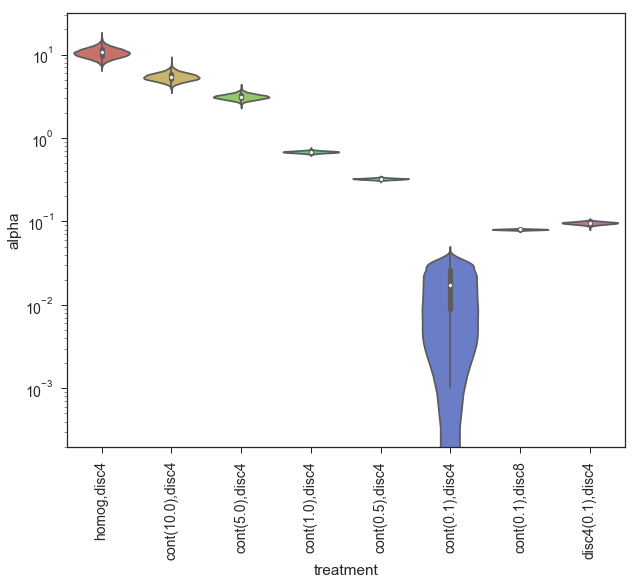

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)

ax = sns.violinplot(x="treatment", y="alpha", data=df, scale="width")
ax.set(yscale="log")
for label in ax.get_xticklabels():
    label.set_rotation(90)

Generally, for higher values of alpha it does OK. When the generating model is no rate-heterogeneity, the estimated alpha is about 10. The exponential prior on this parameter is probably keeping it from rising much higher but a value of 10 is indicative of very little variation in rates. When the generating value is 10, the estimated value is a bit lower (about 7). What is obvious, however, is things go badly awry for a generating alpha of 0.1. Plotting that density alone gives this:

[<matplotlib.text.Text at 0x10b6c3410>, <matplotlib.text.Text at 0x10b1ce710>]

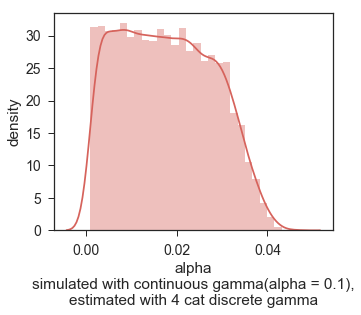

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(5,4)

sns.distplot(df_001.filter(['alpha'], axis=1))
ax.set(xlabel='alpha\nsimulated with continuous gamma(alpha = 0.1),\nestimated with 4 cat discrete gamma', 
       ylabel='density')

Clearly this is failing very badly to recover the generating value. This problem is also affecting some of the other estimated parameters. For example for this particular case the evolutionary rate is over-estimated by about 10-15% (in blue, below):

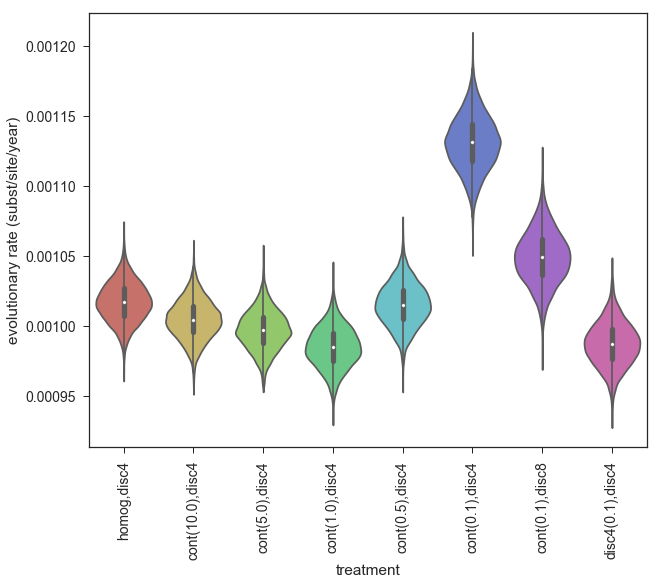

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)

ax = sns.violinplot(x="treatment", y="meanRate", data=df, cut=0, scale="width")
for label in ax.get_xticklabels():
    label.set_rotation(90)
ax.set_ylabel('evolutionary rate (subst/site/year)')

What seems to be the problem is that when we simulated the data we simulated under a continuous gamma distribution (the rate for each site was drawn independently from this distribution) whereas we are estimating using a very rough approximation (a discretized form with 4 categories). Increasing the number of categories to 8 helps a bit (purple, above) and presumably as the number of categories increases the approximation gets better (but the computation burden goes up as well). If we simulate using a 4 category discretized gamma and then reconstruct under this, we get excellent results (both alpha and evolutionary rate recovered correctly) - most right-hand density, above.

In the end, I don't think this is too important because neither the continuous gamma or the discretized gamma are likely to be the actual generating process so we can't predict the effect of misspecifying this on our parameter estimates. However, it seems unlikely that increasing the number of rate categories would make the model fit worse, so if we get a density for alpha that looks like that, above, it may be worth trying 8 categories to see if that changes any results.

The final caveat is that this may be an issue when simulating data in order to test the abiity of different software packages to infer parameters.